# KE5105 - Building Electrical Consumption Forecasting

# Extract, Transform and Load Data 3 - Data Exploration

## Summary of Findings

To be filled in ...

## Load libraries

In [1]:
%matplotlib inline

import myUtilities as myUtils
import pandas as pd
import matplotlib.pyplot as plt
import math
import pickle
import random

## Load Data

In [2]:
RAW_DATA_PATH = "source/105 building data"
COMBINED_DATA_PATH = "source/combined_bldg_data"

# This function combines all the raw time series PWM data in separate csv files into one csv file for a building.
# It also performs date/time and string to numeric conversions.
def combine_csv_files_by_bldg(name, input_data_path=RAW_DATA_PATH, output_data_path=COMBINED_DATA_PATH):

    bldg_data_list = myUtils.load_data_by_bldg(name, input_data_path)

    # Convert the date/time for all the dataframes in the list.
    for i in bldg_data_list:
        if not i[3].empty:
            if myUtils.is_day_first(i[0], i[3]):
                i[3].loc[:, 'Pt_timeStamp'] = pd.to_datetime(i[3].loc[:, 'Pt_timeStamp'], dayfirst=True)
            else:
                i[3].loc[:, 'Pt_timeStamp'] = pd.to_datetime(i[3].loc[:, 'Pt_timeStamp'])

    # Convert the strings to floats for all the dataframes in the list.
    for i in bldg_data_list:
        if not i[3].empty:
            for j in i[3].iloc[:, 1:].columns:
                i[3][j] = i[3][j].astype('str').apply(lambda x: x.replace(',', '')).astype('float')

    # Concatenate the list of dataframes into 1 single dataframe.
    df_list = []
    for i in bldg_data_list:
        df_list.append(i[3])
    bldg_data_df = pd.concat(df_list)

    # Reindex the dataframe using the year/month/day/time, add missing values for any period with no files.
    bldg_data_df.set_index('Pt_timeStamp', inplace=True)
    all_dates = pd.date_range('5/2015', '8/2018', freq='30min')
    bldg_data_df = bldg_data_df.reindex(all_dates)
    bldg_data_df.sort_index(inplace=True)

    # Copy index (i.e. Pt_timeStamp) back to a column
    bldg_data_df.insert(0, 'Pt_timeStamp', bldg_data_df.index)
    bldg_data_df.reset_index(drop=True, inplace=True)

    # Save the dataframe as csv file. Do not write row names (i.e. index 0,1,2,3,4,...)
    bldg_data_df.to_csv(output_data_path + '/' + name + '.csv', index=False)

    return None

In [3]:
## Combine the csv files for the building into 1 file.
combine_csv_files_by_bldg('SDE-2')

In [4]:
# Read the csv file.
sde2_df = pd.read_csv('source/combined_bldg_data/SDE-2-old.csv', index_col=0, parse_dates=True)

## Explore the Data

In [5]:
# From 1 May 2015 (including) to 1 Aug 2018 (not including), there are 1188 days (ref planetcalc.com). Total number of observations = 1188 x 48 + 1 = 57025.
sde2_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 57025 entries, 2015-05-01 00:00:00 to 2018-08-01 00:00:00
Data columns (total 6 columns):
BTU SDE 2        882 non-null float64
BTU-SDE2         40412 non-null float64
PWM SDE 2 AC     882 non-null float64
PWM SDE 2 MSB    882 non-null float64
PWM SDE 2 SSB    882 non-null float64
PWM-SDE2 SSB     40412 non-null float64
dtypes: float64(6)
memory usage: 3.0 MB


In [6]:
sde2_df.iloc[:5, :]

,BTU SDE 2,BTU-SDE2,PWM SDE 2 AC,PWM SDE 2 MSB,PWM SDE 2 SSB,PWM-SDE2 SSB
Pt_timeStamp,,,,,,
2015-05-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-01 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-01 01:30:00,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
sde2_df.iloc[len(sde2_df)-5:, :]

,BTU SDE 2,BTU-SDE2,PWM SDE 2 AC,PWM SDE 2 MSB,PWM SDE 2 SSB,PWM-SDE2 SSB
Pt_timeStamp,,,,,,
2018-07-31 22:00:00,NaN,1170972.13,NaN,NaN,NaN,3499722.75
2018-07-31 22:30:00,NaN,1170972.13,NaN,NaN,NaN,3499737.75
2018-07-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-31 23:30:00,NaN,NaN,NaN,NaN,NaN,NaN
2018-08-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN


BTU SDE 2, BTU-SDE2 and PWM SDE 2 SSB, PWM-SDE2 SSB look like the same columns. We need to remove **whitespaces** and **dashes** to correctly concatenate the csv files (i.e. merge the columns).

In [8]:
sde2_PWM_columns = []
for i in sde2_df.columns:
    if 'PWM' in i:
        sde2_PWM_columns.append(i)
sde2_PWM_columns

['PWM SDE 2 AC', 'PWM SDE 2 MSB', 'PWM SDE 2 SSB', 'PWM-SDE2 SSB']

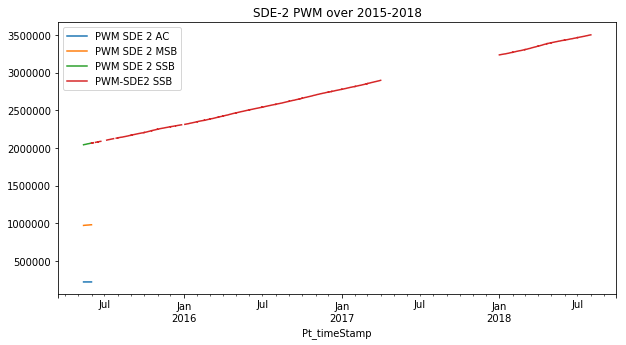

In [9]:
sde2_df.loc[:, sde2_PWM_columns].plot(figsize=(10, 5), title='SDE-2 PWM over 2015-2018')

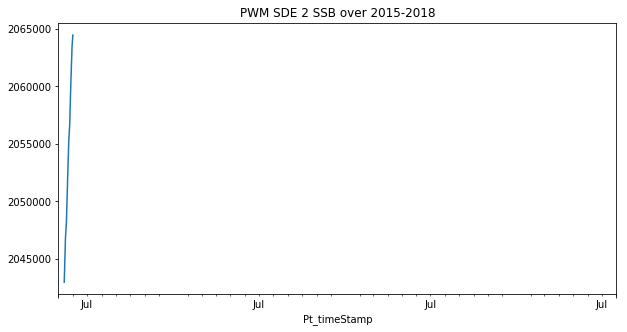

In [10]:
sde2_df['PWM SDE 2 SSB'].plot(figsize=(10, 5), title='PWM SDE 2 SSB over 2015-2018', xticks=['2015-05-01 00H', '2018-08-01 00H'])

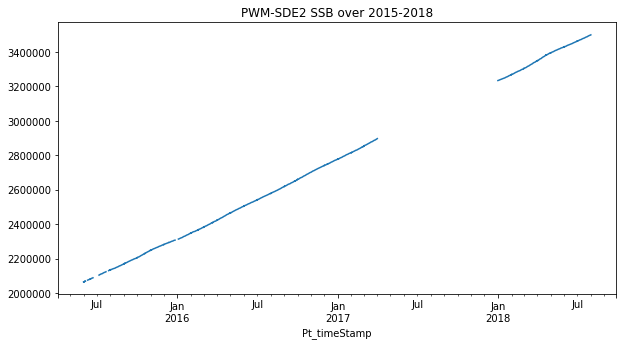

In [11]:
sde2_df['PWM-SDE2 SSB'].plot(figsize=(10, 5), title='PWM-SDE2 SSB over 2015-2018')

In [12]:
# Merge the columns 'PWM SDE 2 SSB' and 'PWM-SDE2 SSB'.
sde2_df['PWMSDE2SSB'] = sde2_df.apply(lambda x: x[4] if math.isnan(x[5]) else x[5], axis=1)
sde2_df['PWMSDE2SSB'].head()

Pt_timeStamp
2015-05-01 00:00:00   NaN
2015-05-01 00:30:00   NaN
2015-05-01 01:00:00   NaN
2015-05-01 01:30:00   NaN
2015-05-01 02:00:00   NaN
Name: PWMSDE2SSB, dtype: float64

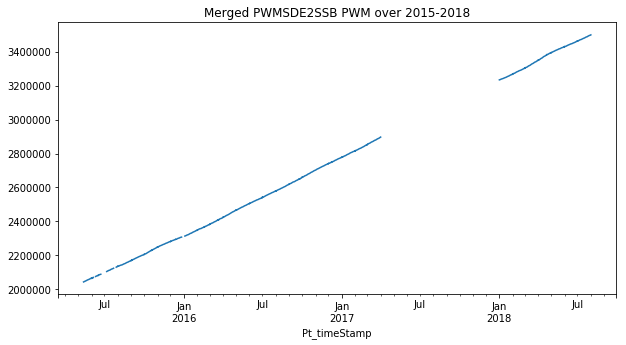

In [13]:
sde2_df['PWMSDE2SSB'].plot(figsize=(10, 5), title='Merged PWMSDE2SSB PWM over 2015-2018')

## Reload the New Pre-processed Data for SDE-2

In [14]:
# ## Combine the csv files for the building into 1 file with all the required pre-processing.
myUtils.combine_csv_files_by_bldg('SDE-2')

In [15]:
# Read the csv file.
new_sde2_df = pd.read_csv('source/combined_bldg_data/SDE-2.csv', index_col=0, parse_dates=True)

In [16]:
new_sde2_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 56418 entries, 2015-05-13 14:00:00 to 2018-07-31 22:30:00
Data columns (total 4 columns):
BTUSDE2       41294 non-null float64
PWMSDE2AC     882 non-null float64
PWMSDE2MSB    882 non-null float64
PWMSDE2SSB    41294 non-null float64
dtypes: float64(4)
memory usage: 2.2 MB


In [17]:
sde2_PWM_columns = []
for i in new_sde2_df.columns:
    if 'PWM' in i:
        sde2_PWM_columns.append(i)
sde2_PWM_columns

['PWMSDE2AC', 'PWMSDE2MSB', 'PWMSDE2SSB']

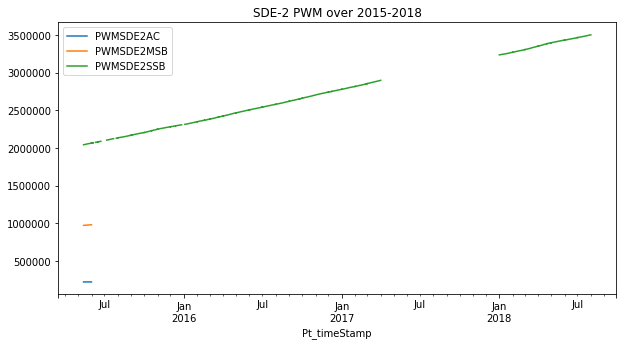

In [18]:
new_sde2_df.loc[:, sde2_PWM_columns].plot(figsize=(10, 5), title='SDE-2 PWM over 2015-2018')

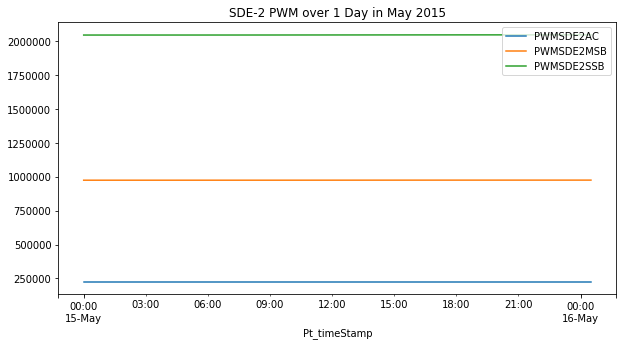

In [19]:
new_sde2_df.loc['2015-05-15 00H':'2015-05-16 00H', sde2_PWM_columns].plot(figsize=(10, 5), title='SDE-2 PWM over 1 Day in May 2015')

## Load the Pre-processed Data for All the Group 1 Buildings

In [20]:
to_load_file = open('source/combined_bldg_data/group1_bldg_list.pickle', 'rb')
group1_bldgs = pickle.load(to_load_file)
group1_bldgs.sort()
group1_bldgs

['AS4', 'AS5', 'CELS', 'E4', 'EA', 'MRB', 'S1A', 'SDE-1', 'SDE-2', 'SDE-3']

In [21]:
# Combine the csv files for each group 1 building into 1 file with all the required pre-processing.
for i in group1_bldgs:
    myUtils.combine_csv_files_by_bldg(i)

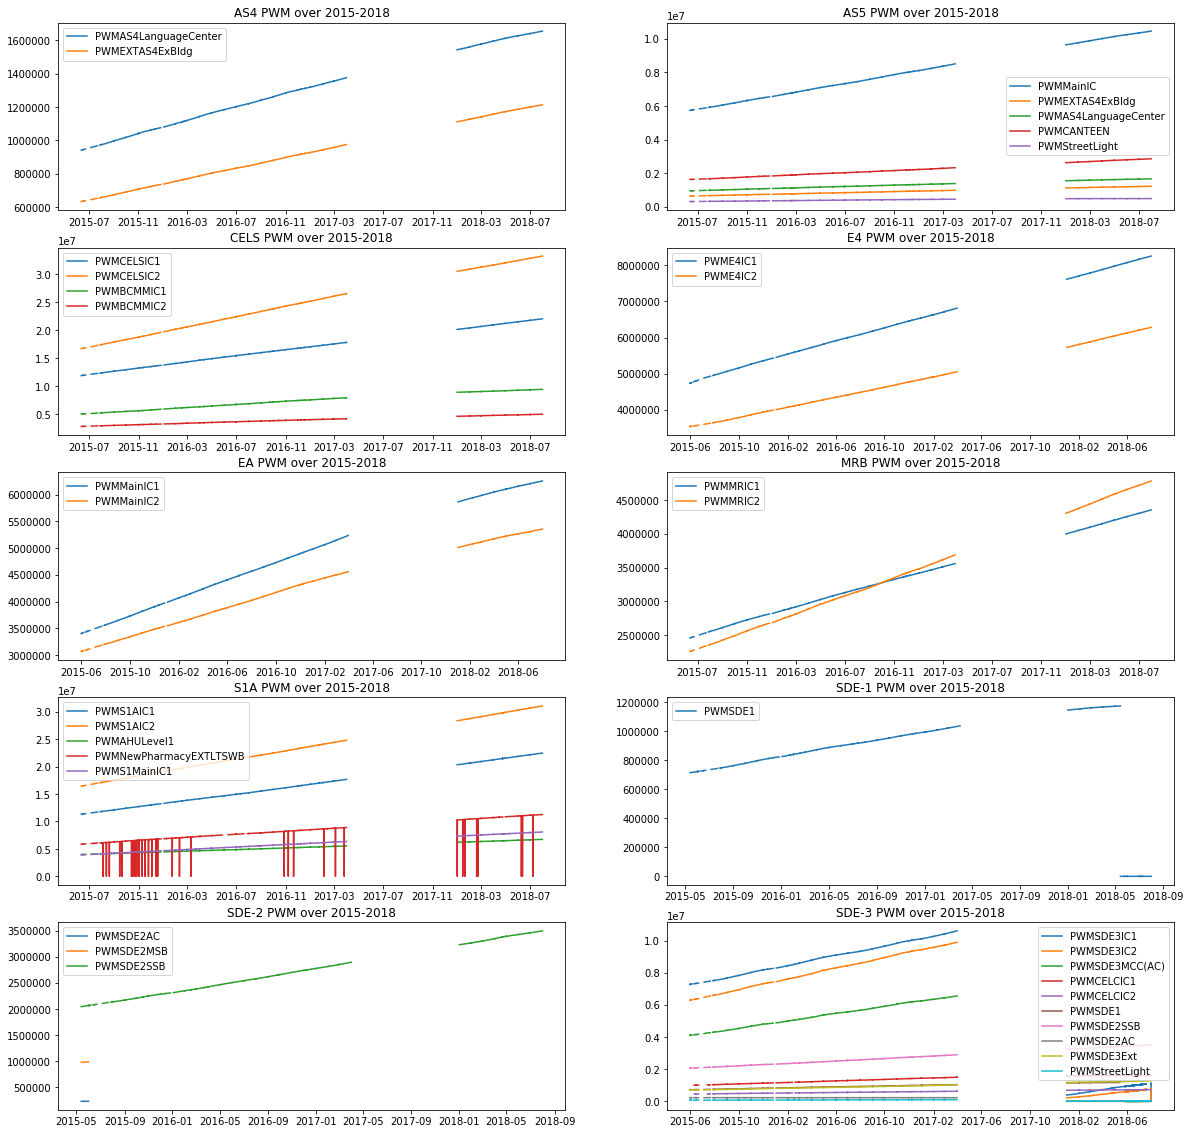

In [34]:
# Plot the cumulative PWM for all the group 1 buildings.
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(20, 20))
list_idx = 0
for row in ax:
    for col in row:
        # Read the csv file which has all the cumulative time series data for a building.
        a_bldg_df = pd.read_csv('source/combined_bldg_data/' + group1_bldgs[list_idx] + '.csv', index_col=0, parse_dates=True)
        # Get the PWM related column names
        a_bldg__PWM_columns = []
        for i in a_bldg_df.columns:
            if 'PWM' in i:
                a_bldg__PWM_columns.append(i)
        # Plot the time series data.
        col.plot(a_bldg_df.loc[:, a_bldg__PWM_columns])
        col.set_title(group1_bldgs[list_idx]+' PWM over 2015-2018')
        col.legend(a_bldg_df.loc[:, a_bldg__PWM_columns])
        list_idx += 1
plt.show()

Note that in building S1A, the PWM for the New Pharmacy EXTLT has **intermittent zero values**.

## Load the Pre-processed Data for All the Group 2 Buildings

In [2]:
to_load_file = open('source/combined_bldg_data/group2_bldg_list.pickle', 'rb')
group2_bldgs = pickle.load(to_load_file)
group2_bldgs.sort()
group2_bldgs[:10]

['AS1',
 'AS2',
 'AS3',
 'AS6',
 'AS7',
 'AS8',
 'Alumni House',
 'BIZ 2',
 'Block B',
 'Brenner Center of Molecular Medicine']

In [4]:
len(group2_bldgs)

In [24]:
# Combine the csv files for each group 2 building into 1 file with all the required pre-processing.
for i in group2_bldgs:
    myUtils.combine_csv_files_by_bldg(i)

In [25]:
# Plot the cumulative PWM for a sample of group 2 buildings.
def plot_cumulative_PWM_10_bldgs(bldg_list, data_path='source/combined_bldg_data/'):
    fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(20, 20))
    list_idx = 0
    for row in ax:
        for col in row:
            # Read the csv file which has all the cumulative time series data for a building.
            a_bldg_df = pd.read_csv(data_path + bldg_list[list_idx] + '.csv', index_col=0, parse_dates=True)
            # Get the PWM related column names
            a_bldg__PWM_columns = []
            for i in a_bldg_df.columns:
                if 'PWM' in i:
                    a_bldg__PWM_columns.append(i)
            # Plot the time series data.
            col.plot(a_bldg_df.loc[:, a_bldg__PWM_columns])
            col.set_title(group1_bldgs[list_idx]+' PWM over 2015-2018')
            col.legend(a_bldg_df.loc[:, a_bldg__PWM_columns])
            list_idx += 1
    plt.show()
    return None

In [26]:
group2_bldgs.index('S1')

64

In [27]:
group2_bldgs[60:70]

['RC4',
 'Raffles Hall',
 'Ridge View',
 'Ridge View Residence',
 'S1',
 'S10',
 'S11',
 'S12',
 'S13',
 'S14']

In [28]:
s10_df = pd.read_csv('source/combined_bldg_data/S10.csv', index_col=0, parse_dates=True)
s10_df.head()

,PWMMDB1S10Level1,PWMMDB1S10Level2,BTUS10AHUL1,BTUS10AHUL2
Pt_timeStamp,,,,
2016-12-09 17:30:00,NaN,NaN,38919.74,30825.37
2016-12-09 18:00:00,NaN,NaN,38928.89,30829.37
2016-12-09 18:30:00,NaN,NaN,38938.04,30833.66
2016-12-09 19:00:00,NaN,NaN,38946.91,30837.09
2016-12-09 19:30:00,NaN,NaN,38954.63,30838.52


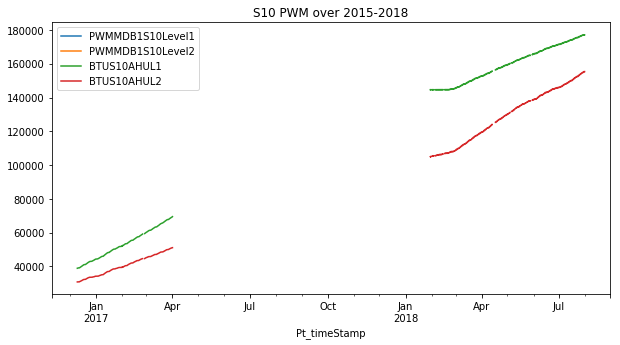

In [29]:
s10_df.plot(figsize=(10, 5), title='S10 PWM over 2015-2018')

In [3]:
bldg_sample_list = random.sample(group2_bldgs, 10)
bldg_sample_list

['EDIC',
 'S2',
 'S14',
 'Li Ka Shing Building',
 'Create',
 'EW1',
 'Ridge View',
 'S8',
 'NUS Centre of Arts',
 'S13']

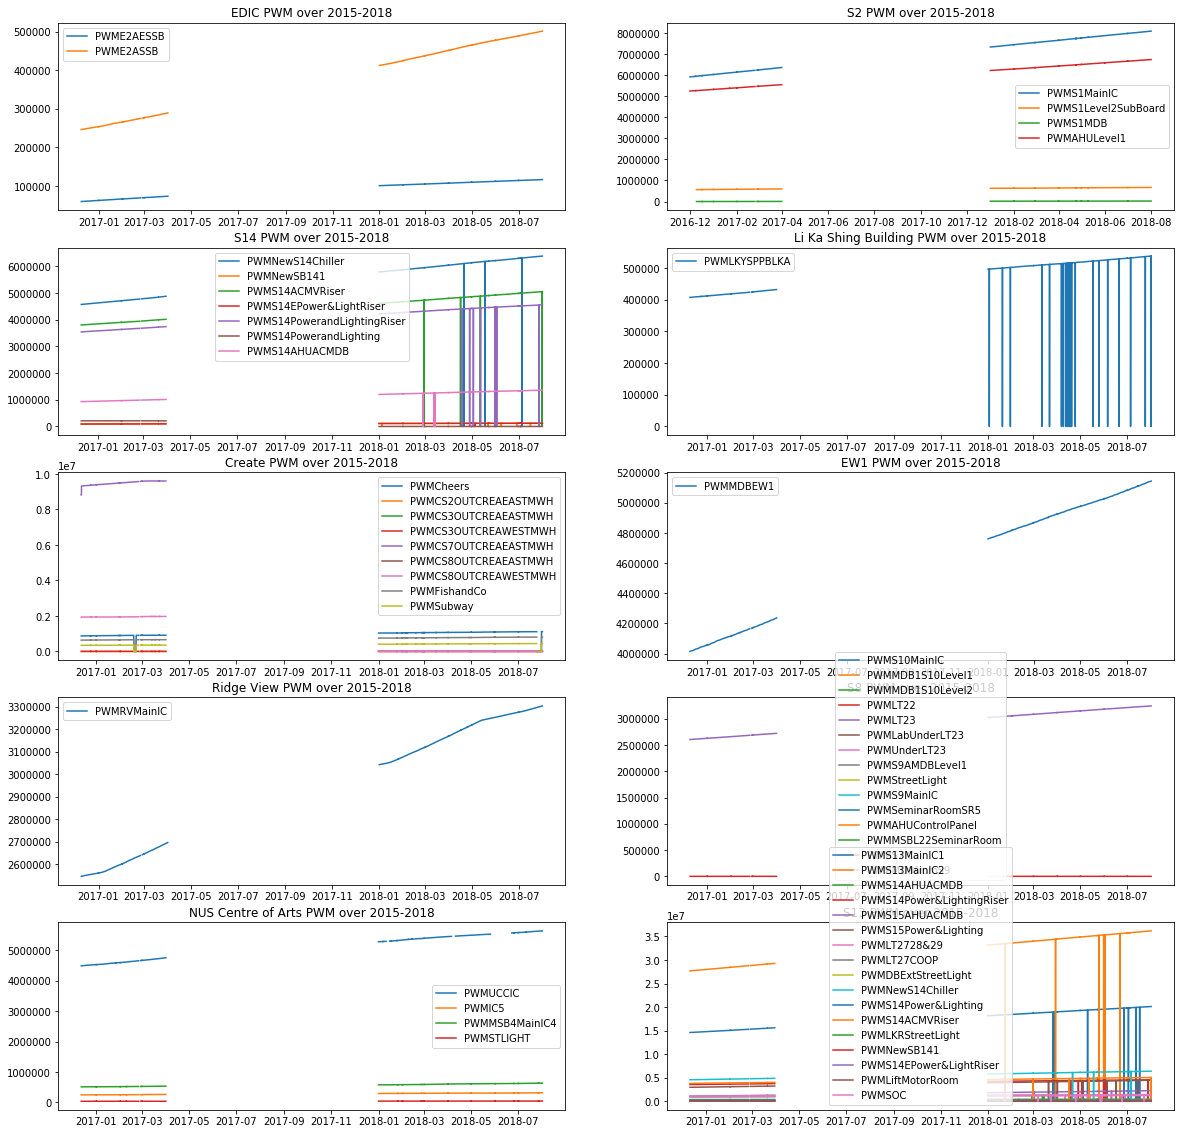

In [4]:
myUtils.plot_cumulative_PWM_upto10_bldgs(bldg_sample_list)